In [1]:
from pandas import read_csv
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
dataframe = pd.read_csv('15days.csv')
dataframe

,ssp,website,click,view,win,date
0,adplay,regnum.ru,0,0,0,2023-10-31 21:00:00
1,adriver,NaN,0,0,1,2023-10-31 21:00:00
2,adriver,1-hd.lorfil.net,0,0,0,2023-10-31 21:00:00
3,adriver,1000.menu,0,0,0,2023-10-31 21:00:00
4,adriver,12knig.com,0,0,0,2023-10-31 21:00:00
...,...,...,...,...,...,...
3489749,videonow,www.starhit.ru,0,0,0,2023-11-15 09:00:00
3489750,videonow,www.tourprom.ru,0,0,1,2023-11-15 09:00:00
3489751,videonow,www.ural.kp.ru,0,0,0,2023-11-15 09:00:00
3489752,videonow,www.yar.kp.ru,0,0,0,2023-11-15 09:00:00


In [3]:
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by='date',ascending=True)
dataframe = dataframe[dataframe.date>=datetime.datetime(2023,11,1)]
dataframe = dataframe[dataframe.date<=datetime.datetime(2023,11,15)]

dataframe = dataframe.reset_index(drop=True)

In [4]:
ssp = ['sape']#,'myvideo','between','videonow','viads','buzzoola','umg']

In [5]:
dataframe

,ssp,website,click,view,win,date
0,sape,music-education.ru,0,0,0,2023-11-01
1,sape,museumrza.ru,0,0,0,2023-11-01
2,sape,mus.zvukofon.com,0,0,0,2023-11-01
3,sape,murdersbuilding.ru,0,0,0,2023-11-01
4,sape,murmansk.bezformata.com,0,0,0,2023-11-01
...,...,...,...,...,...,...
3300697,myvideo,forpost-film.ru,0,1,3,2023-11-15
3300698,myvideo,forever-hdrezka.net,0,0,0,2023-11-15
3300699,myvideo,forest-culture.narod.ru,0,0,0,2023-11-15
3300700,myvideo,forum.georgia.iliko.ru,0,0,0,2023-11-15


In [6]:
def plot_df(df,el):
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot (df.date[:], df.view[:] , linewidth= 3,color='blue' ) 
    plt.xlabel('date')
    plt.ylabel('view')
    ax.set_title(str(el))
    plt.show()

In [7]:
def find_med(df):
    l = [datetime.datetime(2023,5,1,0,0,0)+datetime.timedelta(hours=24*i) for i in range(200) ]
    df_new = df.groupby(pd.cut(df['date'], l))[['view']].max()
    df_new = df_new.reset_index()
    
    med_view = df_new.view.median()
    print(df_new)
    return med_view

In [8]:
def crop_df(df,mltpl):
    med_view = find_med(df)
    print('number of extras = ',len(df.loc[df.view>mltpl*med_view,'view']))
    df.loc[df.view>mltpl*med_view,'view'] = mltpl*med_view

In [9]:
def predict(model,scaled_view,n_input):
    predictions = []
    n_features = 1
    for i in range(len(scaled_view)-n_input):
        first_eval_batch = scaled_view[i:i+n_input]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
        current_pred = model.predict(current_batch)[0]
        predictions.append(current_pred)
    return predictions

In [10]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
    
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)
    
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)

        return context

In [11]:
from tensorflow import keras
def LSTM_with_attention(lstm_units, dense_units, input_shape,lr):
    x=Input(shape=input_shape)
    LSTM_layer = LSTM(lstm_units, return_sequences=True, activation='relu')(x)
    attention_layer = attention()(LSTM_layer)
    outputs=Dense(dense_units, trainable=True, activation='tanh')(attention_layer)
    model=Model(x,outputs)
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=opt)
    return model    

sape
                   date  click   view     win
0   2023-11-01 00:00:00    569  73319  189316
1   2023-11-01 01:00:00    467  59929  159957
2   2023-11-01 02:00:00    574  74093  184983
3   2023-11-01 03:00:00    763  86207  204288
4   2023-11-01 04:00:00    894  93302  206983
..                  ...    ...    ...     ...
332 2023-11-14 20:00:00    175  15194   43144
333 2023-11-14 21:00:00     82  17281   43644
334 2023-11-14 22:00:00     61  15158   39303
335 2023-11-14 23:00:00     56  11514   30396
336 2023-11-15 00:00:00     38   9210   27217

[337 rows x 4 columns]


C:\Users\1111\AppData\Local\Temp\ipykernel_11648\2485302455.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['date']).sum()


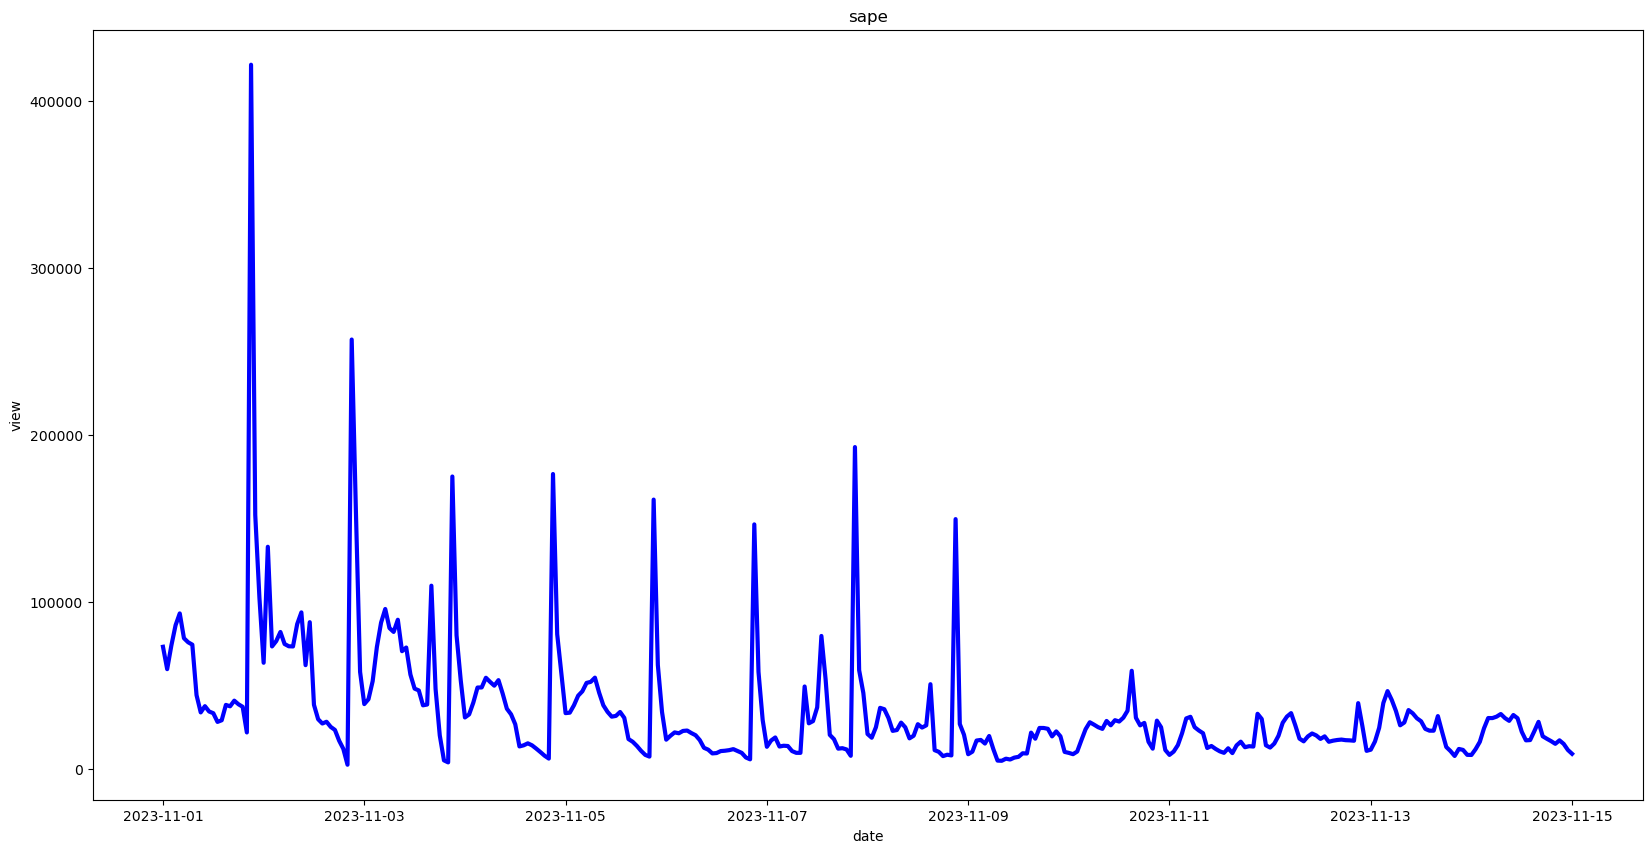

                         date     view
0    (2023-05-01, 2023-05-02]      NaN
1    (2023-05-02, 2023-05-03]      NaN
2    (2023-05-03, 2023-05-04]      NaN
3    (2023-05-04, 2023-05-05]      NaN
4    (2023-05-05, 2023-05-06]      NaN
..                        ...      ...
194  (2023-11-11, 2023-11-12]  33182.0
195  (2023-11-12, 2023-11-13]  39558.0
196  (2023-11-13, 2023-11-14]  46768.0
197  (2023-11-14, 2023-11-15]  33054.0
198  (2023-11-15, 2023-11-16]      NaN

[199 rows x 2 columns]
number of extras =  2


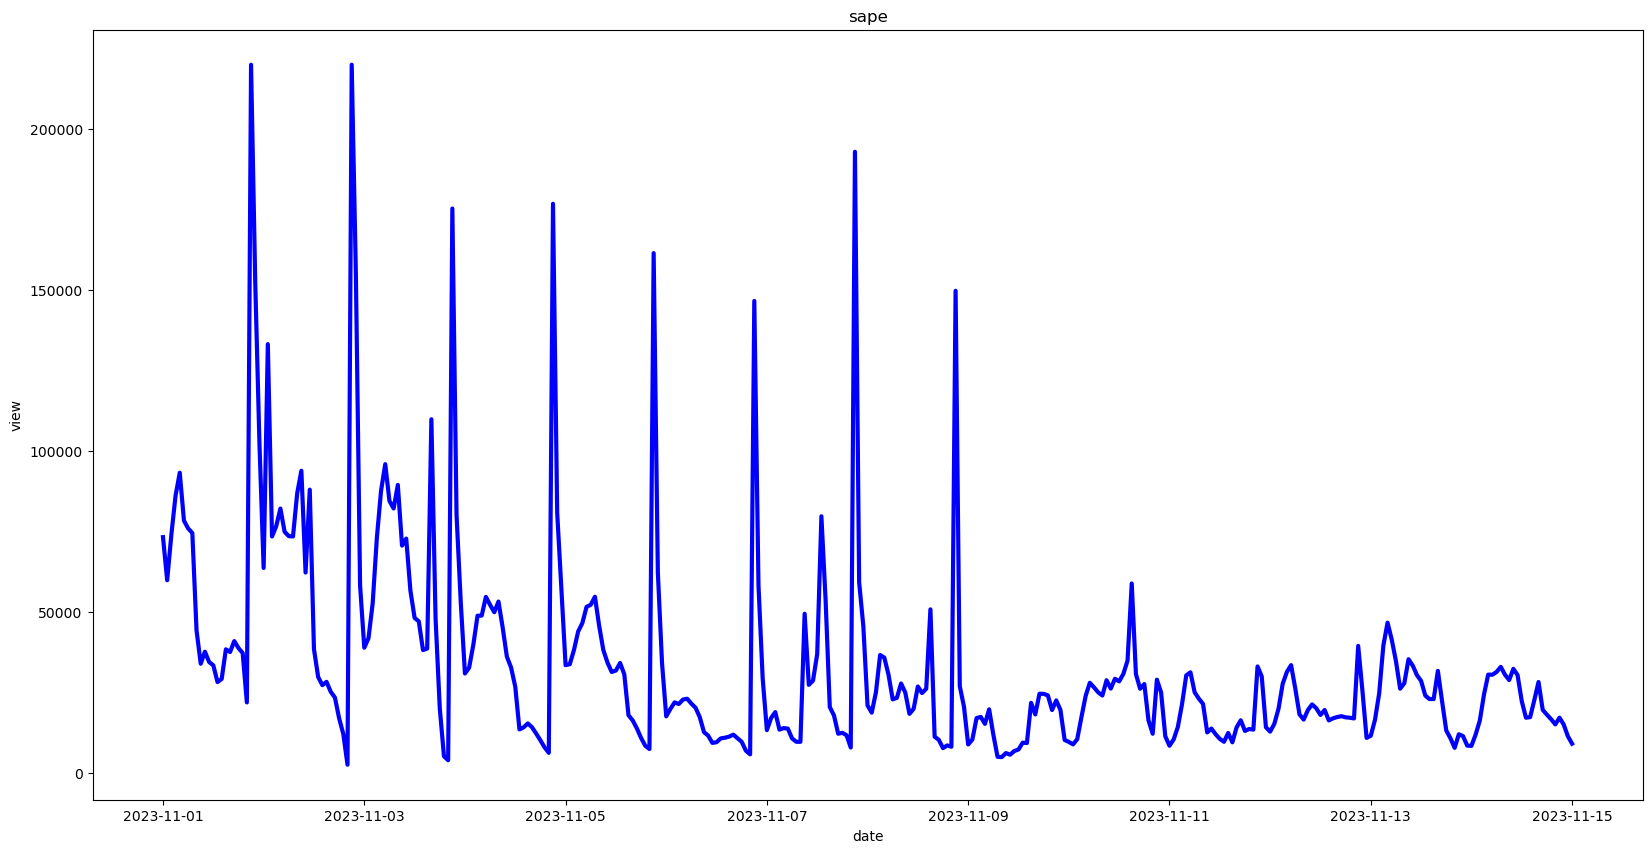

1st 25 raws
                  date  click    view     win  scaled_view
0  2023-11-01 00:00:00    569   73319  189316     0.325152
1  2023-11-01 01:00:00    467   59929  159957     0.263517
2  2023-11-01 02:00:00    574   74093  184983     0.328715
3  2023-11-01 03:00:00    763   86207  204288     0.384477
4  2023-11-01 04:00:00    894   93302  206983     0.417135
5  2023-11-01 05:00:00    875   78432  179690     0.348688
6  2023-11-01 06:00:00    903   76013  168817     0.337553
7  2023-11-01 07:00:00    925   74583  158442     0.330970
8  2023-11-01 08:00:00    438   44373   94896     0.191911
9  2023-11-01 09:00:00    335   34015   66789     0.144233
10 2023-11-01 10:00:00    330   37756   67958     0.161453
11 2023-11-01 11:00:00    310   34563   65865     0.146755
12 2023-11-01 12:00:00    292   33527   63434     0.141987
13 2023-11-01 13:00:00    263   28332   50764     0.118074
14 2023-11-01 14:00:00    244   29308   49504     0.122566
15 2023-11-01 15:00:00    287   38501   5943

INFO:tensorflow:Assets written to: sape\assets


INFO:tensorflow:Assets written to: sape\assets


1/1 [==============================] - 0s 17ms/step
test:
     index                date  click    view     win  scaled_view  \
0       24 2023-11-02 00:00:00    468   63744  170325     0.281078   
1       25 2023-11-02 01:00:00    983  133207  363274     0.600821   
2       26 2023-11-02 02:00:00    671   73520  194324     0.326077   
3       27 2023-11-02 03:00:00    705   76715  196971     0.340784   
4       28 2023-11-02 04:00:00    729   82174  211234     0.365912   
..     ...                 ...    ...     ...     ...          ...   
308    332 2023-11-14 20:00:00    175   15194   43144     0.057598   
309    333 2023-11-14 21:00:00     82   17281   43644     0.067205   
310    334 2023-11-14 22:00:00     61   15158   39303     0.057433   
311    335 2023-11-14 23:00:00     56   11514   30396     0.040659   
312    336 2023-11-15 00:00:00     38    9210   27217     0.030053   

       predictions  scaled_predictions  
0     [0.28628954]        64876.258040  
1     [0.30902424] 

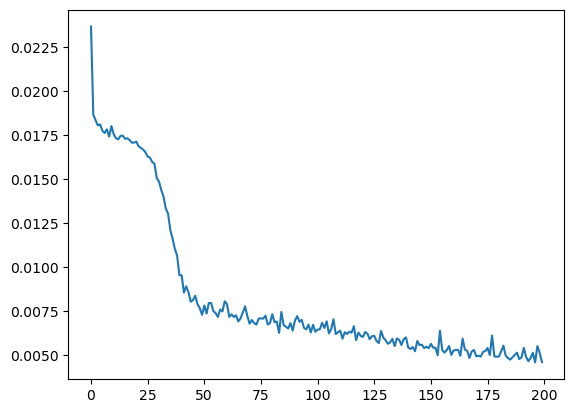

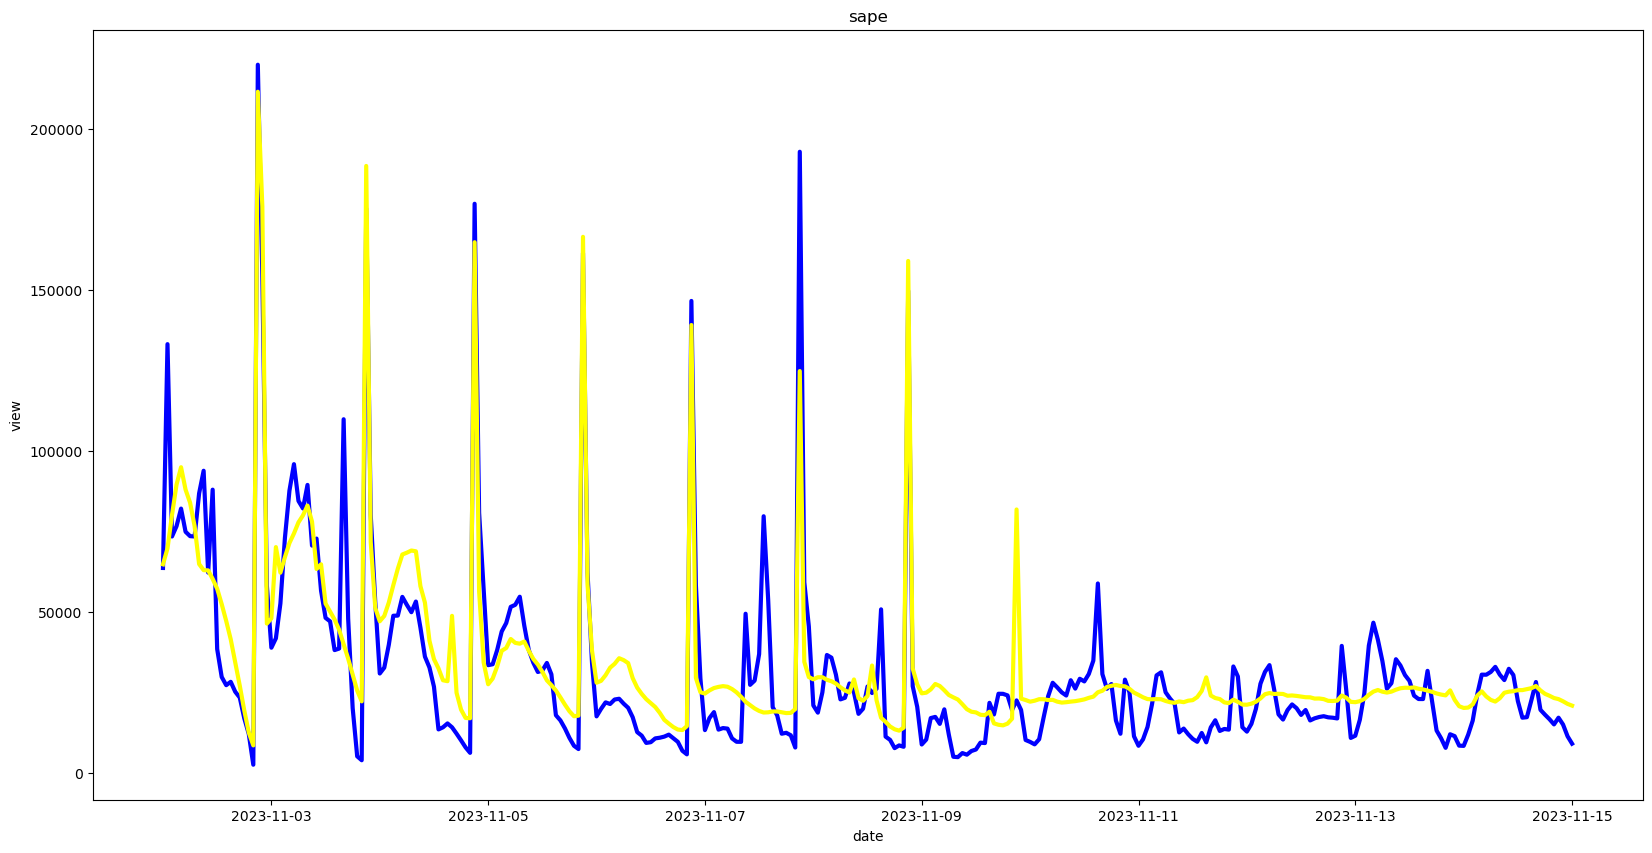

--------------------------


In [12]:
n_input = 24
TEST = pd.DataFrame()
for el in ssp:
    print(el)
    df = dataframe[dataframe.ssp == el]
    df = df.groupby(['date']).sum()   
    #df['click_prob'] = df.click / df.win * 100
    df = df.fillna(0)
    df = df.reset_index()
    

    
    print(df)
    plot_df(df,el)
    crop_df(df,1.5)
    plot_df(df,el)
    scaler = MinMaxScaler()
    arr = np.array(df.view).reshape(-1, 1)
    scaler.fit(arr)
    scaled_view = scaler.transform(arr)
    df['scaled_view'] = scaled_view
    

    train = df[df.date < datetime.datetime(2023,11,14)]
    test = df[df.date >= datetime.datetime(2023,11,13)]
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
        

    generator = TimeseriesGenerator(train.scaled_view, train.scaled_view, length=n_input, batch_size=1)
    print('1st 25 raws')
    print(df[:25])
    print('generator:')
    print(generator[0])

    model_lstm_attention = LSTM_with_attention(lstm_units=100, dense_units=1, input_shape=(n_input,1),lr=0.0001)
    model_lstm_attention.summary()
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", restore_best_weights=True, patience=10,min_delta = 0.000001)
    #model_lstm_attention.fit(generator, epochs=200, batch_size=50, callbacks=[early_stopping])
    model_lstm_attention.fit(generator, epochs=200, batch_size=50)
    model_lstm_attention.save('models_15d_view/'+str(el))
    
    
    model_lstm_attention.save(str(el))
    
    loss_per_epoch = model_lstm_attention.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    
    
    predictions = predict(model_lstm_attention,np.array(df.scaled_view),n_input)
    #predictions_train = predict(model_lstm_attention,np.array(df.scaled_view),n_input)
    
    df = df[n_input:]
    df['predictions'] = predictions
    df['scaled_predictions'] = scaler.inverse_transform(predictions)
    df = df.reset_index()
    print('test:')
    print(df)

    ll = len(df)
    print(ll)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot (df.date[:], df.view[:] , linewidth= 3,color='blue' ) 
    plt.plot (df.date[:], df.scaled_predictions[:] , linewidth= 3,color='yellow' ) 
    plt.xlabel('date')
    plt.ylabel('view')
    ax.set_title(str(el))
    plt.show()    
    
    
    TEST = pd.concat([TEST,test])
    print('--------------------------')

In [13]:
test

,date,click,view,win,scaled_view
0,2023-11-13 00:00:00,71,11686,28158,0.041451
1,2023-11-13 01:00:00,83,16592,36868,0.064033
2,2023-11-13 02:00:00,105,24780,54105,0.101723
3,2023-11-13 03:00:00,124,39667,74998,0.170249
4,2023-11-13 04:00:00,154,46768,81427,0.202936
5,2023-11-13 05:00:00,112,41490,75250,0.178641
6,2023-11-13 06:00:00,109,34856,64455,0.148104
7,2023-11-13 07:00:00,109,26283,49574,0.108642
8,2023-11-13 08:00:00,122,27976,53052,0.116435
9,2023-11-13 09:00:00,195,35419,66375,0.150696


In [14]:
TEST.to_csv('15D_VIEW.csv')

In [15]:
TEST

,date,click,view,win,scaled_view
0,2023-11-13 00:00:00,71,11686,28158,0.041451
1,2023-11-13 01:00:00,83,16592,36868,0.064033
2,2023-11-13 02:00:00,105,24780,54105,0.101723
3,2023-11-13 03:00:00,124,39667,74998,0.170249
4,2023-11-13 04:00:00,154,46768,81427,0.202936
5,2023-11-13 05:00:00,112,41490,75250,0.178641
6,2023-11-13 06:00:00,109,34856,64455,0.148104
7,2023-11-13 07:00:00,109,26283,49574,0.108642
8,2023-11-13 08:00:00,122,27976,53052,0.116435
9,2023-11-13 09:00:00,195,35419,66375,0.150696
